## Preconfiguration

In [1]:
# install packages
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.9 MB/s eta 0:00:00


In [2]:
# load libraries
import keras
import keras_nlp
import time
import os
import matplotlib.pyplot as plt
from datasets import load_dataset

In [3]:
# configure environment

# operating system environment
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

# training environment
token_length_limit = 256
data_length_limit = 100
lora_name = "cakeboss"
lora_rank = 4
learning_rate = 1e-4
num_epochs = 20
model_id = "gemma2_instruct_2b_en"
batch_size = 1

## Model Initialization

In [4]:
# load Gemma model
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# functions for Gemma model
tick_start = 0
def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"Total time elapsed: {time.time() - tick_start}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_length_limit)
    print("\nGemma Output:")
    print(output)
    tock()

In [6]:
# inference test
text_gen("Hi, nice to meet you! Introduce youself!")


Gemma Output:
<start_of_turn>user
Hi, nice to meet you! Introduce youself!<end_of_turn>
<start_of_turn>model
Hello! It's nice to meet you too. 😊 

I'm Gemma, an AI assistant created by the Gemma team. I'm a large language model, which means I'm really good at understanding and generating text.  

I can help you with things like:

* **Answering your questions:**  I've been trained on a massive amount of text data, so I can provide information on a wide range of topics.
* **Writing different kinds of creative content:**  I can help you write stories, poems, articles, and more.
* **Summarizing text:**  Give me a long piece of writing, and I can give you a concise summary.
* **Translating languages:**  I can translate text between many different languages.

What can I do for you today? 
<end_of_turn>
Total time elapsed: 36.88043999671936s


## Loading Dataset

In [7]:
# load example toy dataset
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
data_set = load_dataset(
    "bebechien/korean_cake_boss",
    split="train"
)

# print result
print("*" * 50)
print("Dataset insight:")
print(data_set)

README.md:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20 [00:00<?, ? examples/s]

**************************************************
Dataset insight:
Dataset({
    features: ['input', 'output'],
    num_rows: 20
})


In [8]:
# format dataset type to Numpy for fast computation
data_set = data_set.with_format("np", columns=["input", "output"], output_all_columns=False)

# print result
print("*" * 50)
print("Dataset examples:")
print(data_set[:1])

**************************************************
Dataset examples:
{'input': array(['안녕하세요,\r\n2주 뒤에 있을 아이 생일을 위해 3호 케이크 3개를 주문하고 싶은데 가능할까요?'],
      dtype='<U53'), 'output': array(['고객님, 안녕하세요.\r\n\r\n2주 뒤 아이 생일을 위한 3호 케이크 2개 주문 문의 감사합니다.\r\n네, 3호 케이크 2개 주문 가능합니다.\r\n\r\n아이 생일 케이크인 만큼 더욱 신경 써서 정성껏 준비하겠습니다. 혹시 원하시는 디자인이나 특별한 요청 사항이 있으시면 편하게 말씀해주세요.\r\n\r\n픽업 날짜와 시간을 알려주시면 더욱 자세한 안내를 도와드리겠습니다.\r\n\r\n다시 한번 문의 감사드리며, 아이 생일 진심으로 축하합니다!\r\n\r\n[가게 이름] 드림'],
      dtype='<U249')}


In [9]:
# create training data (strings) using dataset
training_data = []

for row in data_set:
    # training data
    item = f"<start_of_turn>user\n{row['input']}<end_of_turn>\n<start_of_turn>model\n{row['output']}<end_of_turn>"

    # limit the length of tokens of each item
    token_length = len(tokenizer(item))
    if token_length > token_length_limit:
        continue 
    else:
        training_data.append(item) 

    # limit the length of 
    data_length = len(training_data)
    if data_length >= data_length_limit:
            break

In [10]:
# test results 
print("*" * 50)
print("The length of training data:")
print(len(training_data))

print("*" * 50)
print("Example:")
print(training_data[0])

**************************************************
The length of training data:
11
**************************************************
Example:
<start_of_turn>user
안녕하세요,
2주 뒤에 있을 아이 생일을 위해 3호 케이크 3개를 주문하고 싶은데 가능할까요?<end_of_turn>
<start_of_turn>model
고객님, 안녕하세요.

2주 뒤 아이 생일을 위한 3호 케이크 2개 주문 문의 감사합니다.
네, 3호 케이크 2개 주문 가능합니다.

아이 생일 케이크인 만큼 더욱 신경 써서 정성껏 준비하겠습니다. 혹시 원하시는 디자인이나 특별한 요청 사항이 있으시면 편하게 말씀해주세요.

픽업 날짜와 시간을 알려주시면 더욱 자세한 안내를 도와드리겠습니다.

다시 한번 문의 감사드리며, 아이 생일 진심으로 축하합니다!

[가게 이름] 드림<end_of_turn>


## LoRA Fine-tuning

In [11]:
# enable LoRA on Gemma model
gemma_lm.backbone.enable_lora(rank=lora_rank) # a LoRA rank of 4 is computationally efficient
gemma_lm.preprocessor.sequence_length = token_length_limit

# use AdamW optimizer, which is common for transformer models
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = 0.01
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# compile the model
gemma_lm.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = optimizer,
    weighted_metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [12]:
# define a custom callback to save LoRA weights and evaluate the model
class SaveLoRACallback(keras.callbacks.Callback):
    def __init__(self, lora_base_name, lora_rank_value):
        super().__init__()
        self.lora_base_name = lora_base_name
        self.lora_rank_value = lora_rank_value
        
    def on_epoch_end(self, epoch, logs=None):
        # save LoRA weights
        lora_file_name = f"/kaggle/working/{self.lora_base_name}_lora_rank{self.lora_rank_value}_epoch{epoch+1}.lora.h5"
        gemma_lm.backbone.save_lora_weights(lora_file_name)
        print(f"LoRA weights saved: {lora_file_name}")
        
        # evaluate the model
        self.evaluate_model()
    
    def evaluate_model(self):
        text_gen("다음에 대한 이메일 답장을 작성해줘.\n\"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?\"")

In [13]:
# train the model
training_history = gemma_lm.fit(
    training_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[SaveLoRACallback(lora_base_name=lora_name, lora_rank_value=lora_rank)]
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 1.7713 - sparse_categorical_accuracy: 0.5515LoRA weights saved: /kaggle/working/cakeboss_lora_rank4_epoch1.lora.h5

Gemma Output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 결혼기념일을 위해 3호 케이크 1개를 주문하고 싶은데 가능할까요?"<end_of_turn>
<start_of_turn>model
##  답장 예시

**제목: Re: 결혼기념일 케이크 주문 문의**

안녕하세요, [주문자 이름]님,

안녕하세요. 결혼기념일 케이크 주문을 받으셨네요! 😊 

3호 케이크 1개를 주문하시면, 멋진 결혼기념일을 축하드립니다! 

[주문 내용에 대한 추가 정보를 적어주세요. 예시: 케이크 종류, 크기, 디자인, 주문 날짜, 배송 지역 등]

[주문 가능 여부에 대한 답변]

* 케이크 주문이 가능합니다. 
* [케이크 주문 가능 여부에 대한 추가 설명]

[케이크 주문 시 추가 정보를 요청할 수 있는 문구]

* [예시: 케이크 디자인에 대한 추가 설명
Total time elapsed: 38.55453300476074s
11/11 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - loss: 1.7637 - sparse_categorical_accuracy: 0.5496 
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 1.6894 - sparse_categorical_accuracy: 0.5614LoRA weights saved: /kaggle/working/cakeboss_lora_rank4_epoch2.lora.h5

Gemma Output:
<start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 결혼기념

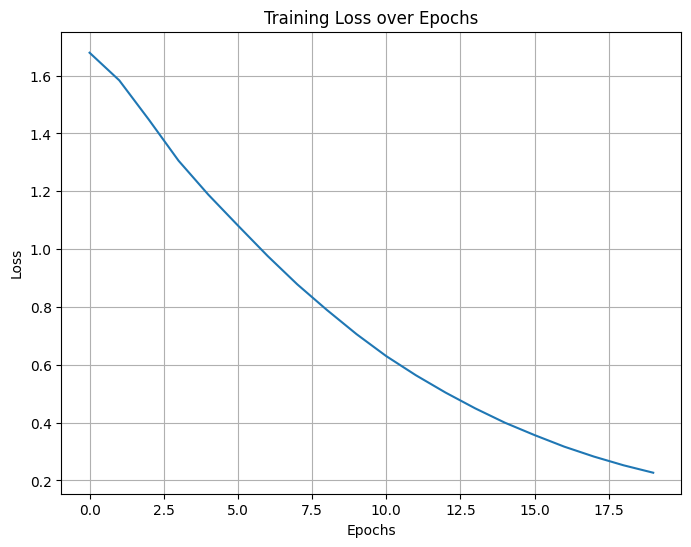

In [14]:
# plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()